In [ ]:
import torch
torch.cuda.is_available()


True

In [ ]:
!pip install -q transformers torch scikit-learn pandas numpy


In [ ]:
import pandas as pd
df=pd.read_csv("UpdatedResumeDataSet.csv")

In [ ]:
df.head(-10)

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
947,Testing,Skill Set OS Windows XP/7/8/8.1/10 Database MY...
948,Testing,â¢ Good logical and analytical skills â¢ Pos...
949,Testing,COMPUTER PROFICIENCY â¢ Basic: MS-Office (Pow...
950,Testing,Computer Skills: â¢ Proficient in MS office (...


In [ ]:
df.shape

(962, 2)

In [ ]:
df.isna().sum()

,0
Category,0
Resume,0


In [ ]:
df['Category'].value_counts()

,count
Category,
Java Developer,84
Testing,70
DevOps Engineer,55
Python Developer,48
Web Designing,45
HR,44
Hadoop,42
Sales,40
Data Science,40


In [ ]:
df['char_len']=df['Resume'].apply(len)
df['char_len'].describe()


,char_len
count,962.000000
mean,3160.364865
std,2886.528521
min,142.000000
25%,1217.250000
50%,2355.000000
75%,4073.750000
max,14816.000000


In [ ]:
print(df['Resume'].iloc[0])

Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling (LDA, NMF), PCA & Neural Nets. * Database Visualizations: Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib, ggplot, Tableau. * Others: Regular Expression, HTML, CSS, Angular 6, Logstash, Kafka, Python Flask, Git, Docker, computer vision - Open CV and understanding of Deep learning.Education Details 

Data Science Assurance Associate 

Data Science Assurance Associate - Ernst & Young LLP
Skill Details 
JAVASCRIPT- Exprience - 24 months
jQuery- Exprience - 24 months
Python- Exprience - 24 monthsCompany Details 
company - Ernst & Young LLP
description - Fraud Investigations and Dispute Services   Assur

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['label']=le.fit_transform(df["Category"])

In [ ]:
df['label'].head()

,label
0,6
1,6
2,6
3,6
4,6


In [ ]:
list(zip(le.classes_, range(len(le.classes_))))


[('Advocate', 0),
 ('Arts', 1),
 ('Automation Testing', 2),
 ('Blockchain', 3),
 ('Business Analyst', 4),
 ('Civil Engineer', 5),
 ('Data Science', 6),
 ('Database', 7),
 ('DevOps Engineer', 8),
 ('DotNet Developer', 9),
 ('ETL Developer', 10),
 ('Electrical Engineering', 11),
 ('HR', 12),
 ('Hadoop', 13),
 ('Health and fitness', 14),
 ('Java Developer', 15),
 ('Mechanical Engineer', 16),
 ('Network Security Engineer', 17),
 ('Operations Manager', 18),
 ('PMO', 19),
 ('Python Developer', 20),
 ('SAP Developer', 21),
 ('Sales', 22),
 ('Testing', 23),
 ('Web Designing', 24)]

In [ ]:
from sklearn.model_selection import train_test_split
train_texts,val_texts,train_labels,val_labels= train_test_split(df['Resume'],df['label'],test_size=0.2,stratify=df['label'],random_state=42)

In [ ]:
len(train_texts),len(val_texts)


(769, 193)

In [ ]:
train_counts=pd.Series(train_labels).value_counts()
val_counts=pd.Series(val_labels).value_counts()
print(train_counts.sort_index())
print(val_counts.sort_index())

label
0     16
1     29
2     21
3     32
4     22
5     19
6     32
7     26
8     44
9     23
10    32
11    24
12    35
13    34
14    24
15    67
16    32
17    20
18    32
19    24
20    38
21    19
22    32
23    56
24    36
Name: count, dtype: int64
label
0      4
1      7
2      5
3      8
4      6
5      5
6      8
7      7
8     11
9      5
10     8
11     6
12     9
13     8
14     6
15    17
16     8
17     5
18     8
19     6
20    10
21     5
22     8
23    14
24     9
Name: count, dtype: int64


In [ ]:
from transformers import BertTokenizer
tokenizer=BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
train_texts,val_texts=train_texts.astype(str).tolist(),val_texts.astype(str).tolist()

train_encodings=tokenizer(train_texts,
                          truncation=True,
                          padding=True,
                          max_length=512
                          )
val_encodings=tokenizer(val_texts,
                        truncation=True,
                        padding=True,
                        max_length=512
                        )

In [ ]:
import torch

class ResumeDataset(torch.utils.data.Dataset):
  def __init__(self,encodings,labels):
    self.encodings=encodings
    self.labels=labels

  def __getitem__(self,idx):
    item={key:torch.tensor(val[idx])
          for key,val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels.iloc[idx])
    return item
  def __len__(self):
    return len(self.labels)

In [ ]:
train_dataset = ResumeDataset(train_encodings, train_labels)
val_dataset=ResumeDataset(val_encodings,val_labels)

In [ ]:
sample = train_dataset[9]
sample.keys()



dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])

In [ ]:
sample['input_ids'].shape
sample['attention_mask'].shape


torch.Size([512])

In [ ]:
from transformers import BertForSequenceClassification
model=BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=len(le.classes_))


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.eval()

with torch.no_grad():
  output=model(
      input_ids=sample['input_ids'].unsqueeze(0),
      attention_mask=sample['attention_mask'].unsqueeze(0),
      labels=sample['labels'].unsqueeze(0)
  )
output

SequenceClassifierOutput(loss=tensor(3.6555), logits=tensor([[ 0.2892, -0.4208,  0.1424, -0.3446, -0.2602,  0.2226,  0.1730,  0.3942,
         -0.1214, -0.0463, -0.3761,  0.3136, -0.1258, -0.2472,  0.0098,  0.0857,
         -0.5026,  0.0976, -0.1716, -0.6292, -0.2579,  0.3407,  0.2882, -0.0269,
          0.4859]]), hidden_states=None, attentions=None)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    save_total_limit=2
)


In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def compute_metrics(eval_pred):
  logits,labels=eval_pred
  preds=np.argmax(logits,axis=1)
  f1=f1_score(labels,preds,average='weighted')
  return {'f1':f1}

In [ ]:
from transformers import Trainer

trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.403290,0.989603
2,No log,0.115948,0.994931
3,No log,0.084716,0.994931


TrainOutput(global_step=291, training_loss=0.4822749501651095, metrics={'train_runtime': 300.6186, 'train_samples_per_second': 7.674, 'train_steps_per_second': 0.968, 'total_flos': 607122554323968.0, 'train_loss': 0.4822749501651095, 'epoch': 3.0})

In [ ]:
trainer.evaluate()


{'eval_loss': 0.11594774574041367,
 'eval_f1': 0.9949308032209586,
 'eval_runtime': 5.8513,
 'eval_samples_per_second': 32.984,
 'eval_steps_per_second': 4.273,
 'epoch': 3.0}

In [ ]:
predictions=trainer.predict(val_dataset)
logits=predictions.predictions
y_true = predictions.label_ids
y_pred = logits.argmax(axis=1)


In [ ]:
model.save_pretrained("./resume_classifier")
tokenizer.save_pretrained("./resume_classifier")


('./resume_classifier/tokenizer_config.json',
 './resume_classifier/special_tokens_map.json',
 './resume_classifier/vocab.txt',
 './resume_classifier/added_tokens.json')

In [ ]:
!pip install pdf2image


In [ ]:
!apt-get update
!apt-get install -y poppler-utils

from pdf2image import convert_from_path
from IPython.display import display
def display_pdf_as_images(pdf_path, dpi=200):
    resume_text, role = predict_resume_file(pdf_path)
    print("\n🤖 PREDICTED ROLE")
    print("=" * 60)
    print(role)
    print("=" * 60)

    pages = convert_from_path(pdf_path, dpi=dpi)

    print(f"📄 Resume Preview ({len(pages)} pages)\n")

    for i, page in enumerate(pages):
        print(f"Page {i+1}")
        display(page)
        continue





<Figure size 1000x1000 with 0 Axes>

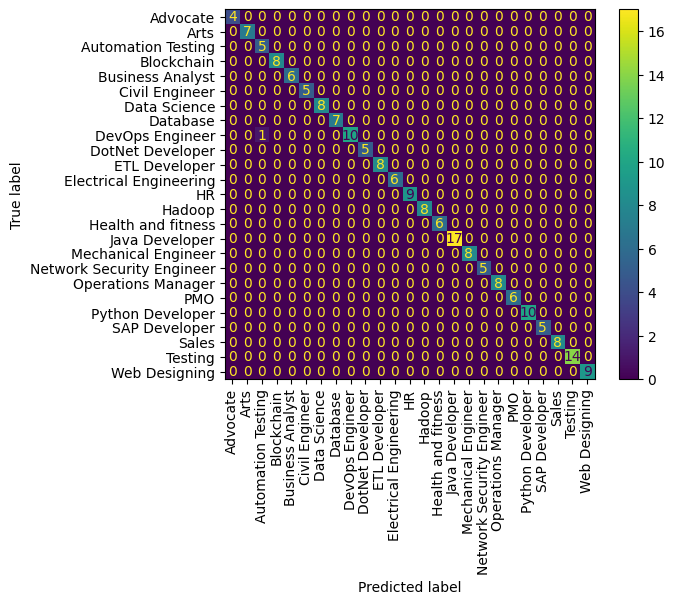

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm=confusion_matrix(y_true,y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=le.classes_  )
plt.figure(figsize=(10,10))
disp.plot(xticks_rotation=90)
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=le.classes_
))


                           precision    recall  f1-score   support

                 Advocate       1.00      1.00      1.00         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       0.83      1.00      0.91         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       1.00      1.00      1.00         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       1.00      1.00      1.00         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       1.00      1.00      1.00         9
                   Hadoop       1.00      1.00      1.00     

In [ ]:
from google.colab import files

uploaded = files.upload()
file_name = list(uploaded.keys())[0]


Saving Resumes.pdf to Resumes (12).pdf



🤖 PREDICTED ROLE
Java Developer
📄 Resume Preview (2 pages)

Page 1


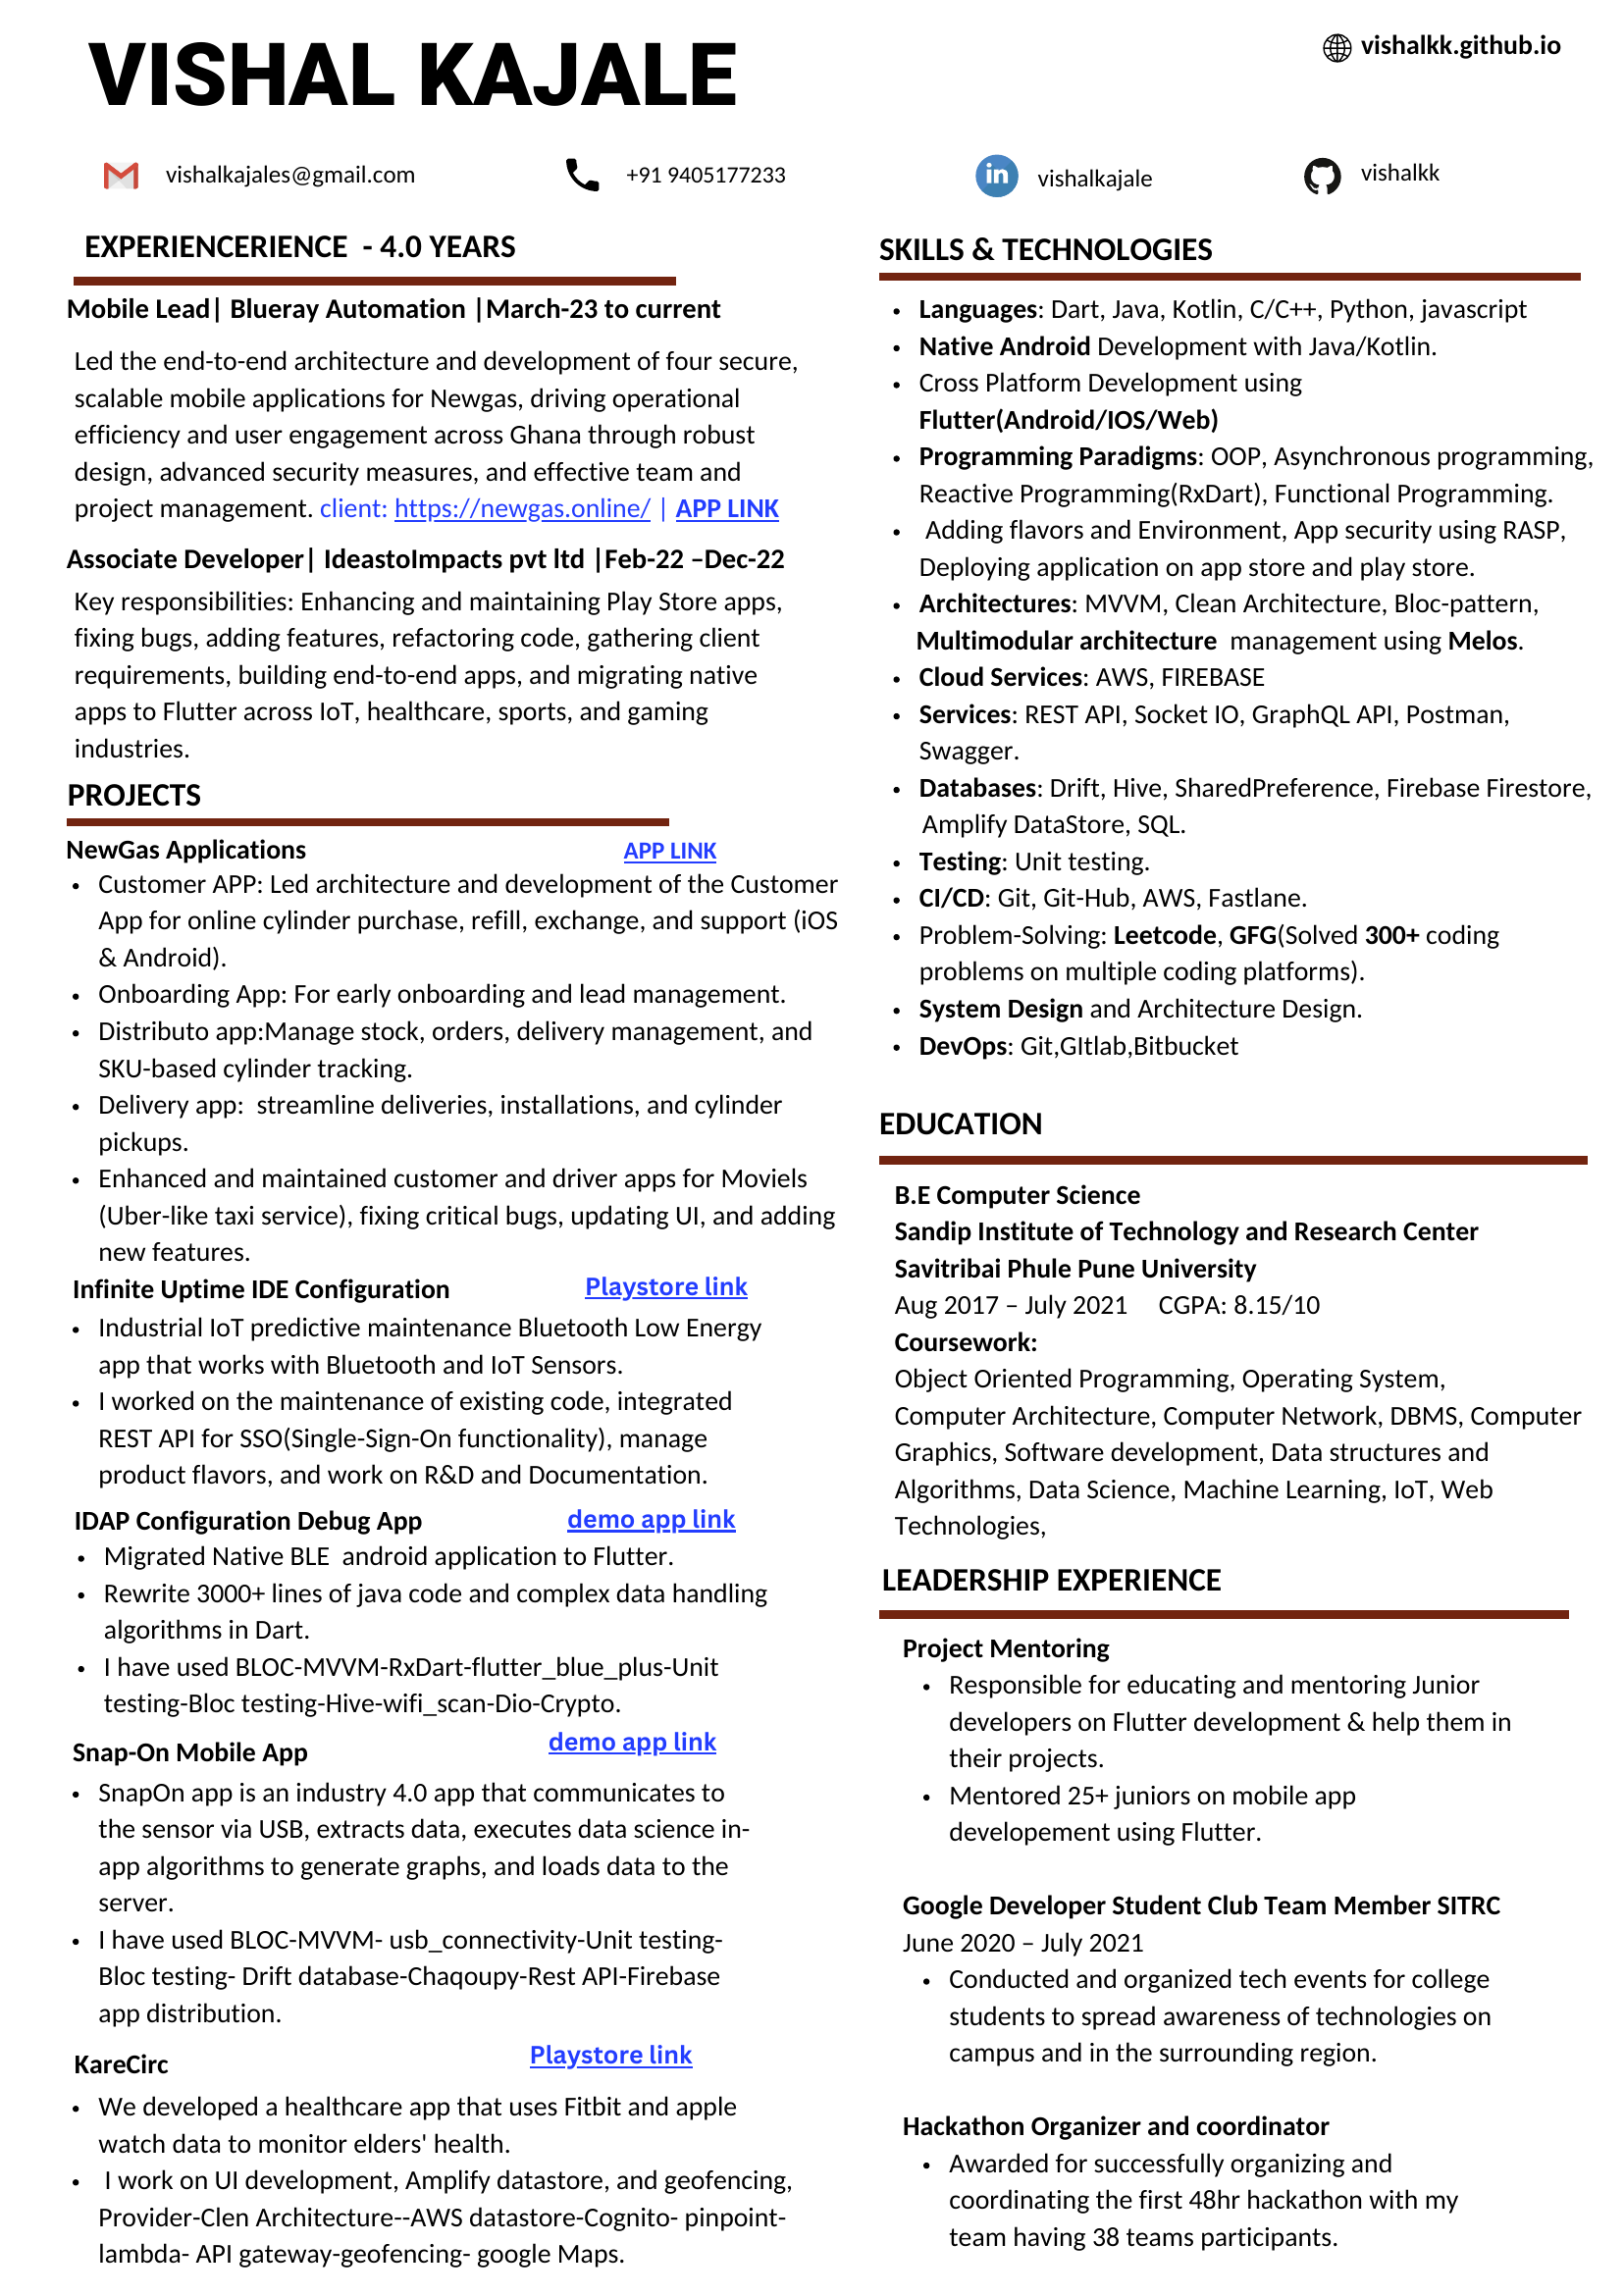

Page 2


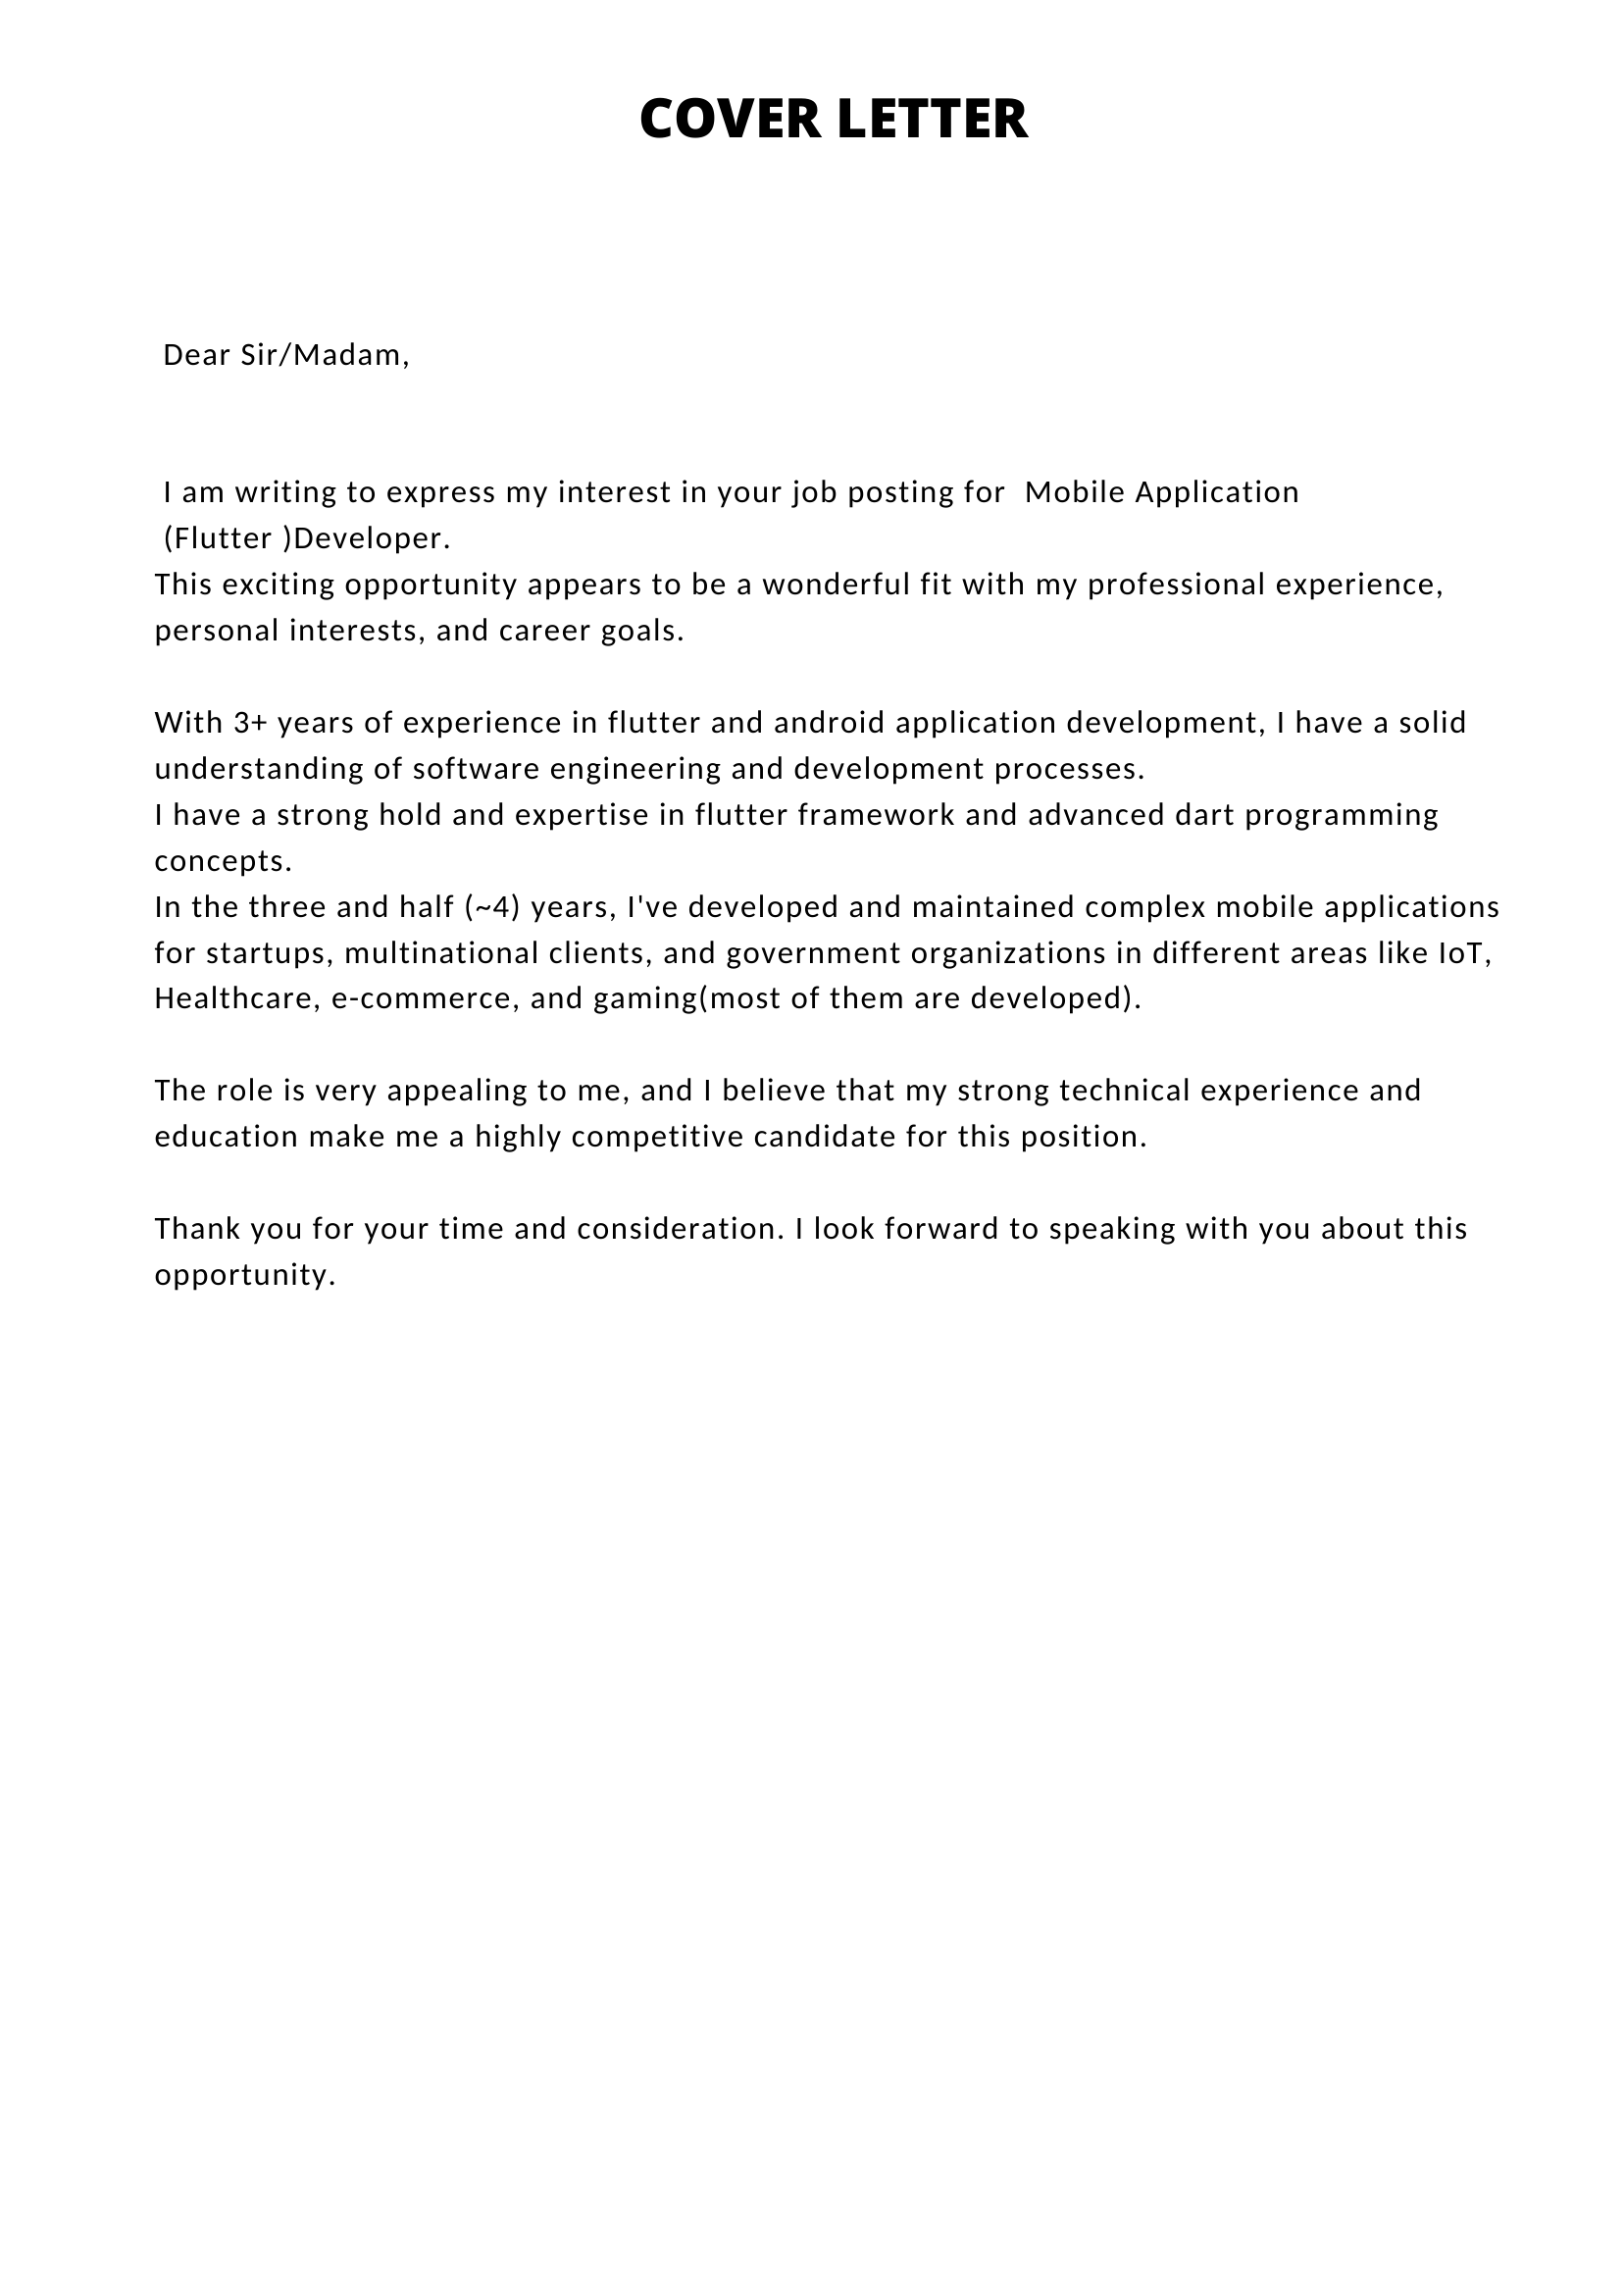

In [ ]:
display_pdf_as_images(file_name)